In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# 0. Install Dependencies and Dataset

## 0.1 Install Python packages

In [ ]:
%%bash
rm -rf sample_data

pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece 
pip -q install kaggle


## 0.2 Download the dataset using the Kaggle API

In [ ]:
%%bash
mkdir ~/.kaggle/
cd ~/.kaggle/
touch kaggle.json
chmod 600 /root/.kaggle/kaggle.json
echo "{\"username\":\"cwcrystal8\",\"key\":\"75ba9516cfea9c5de8e657080f7428bd\"}" > kaggle.json

cd /content/

kaggle datasets download -d mateibejan/multilingual-lyrics-for-genre-classification
unzip multilingual-lyrics-for-genre-classification.zip
rm test.csv
rm multilingual-lyrics-for-genre-classification.zip
mv train.csv data.csv


Archive:  multilingual-lyrics-for-genre-classification.zip
  inflating: test.csv                
  inflating: train.csv               


100%|##########| 103M/103M [00:01<00:00, 96.2MB/s] 


## 0.3 Clone the Github repo

In [ ]:
%%bash
cd /content/
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6.864-lyric-analysis
git clone "https://github.com/sohinik/6.864-lyric-analysis.git"

Cloning into '6.864-lyric-analysis'...


# 1. Clean and Format the Data

In [ ]:
import numpy as np
import os
import random
import torch
from torch import cuda

os.chdir("/content/6.864-lyric-analysis")
print("Current Working Directory:", os.getcwd())

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(seed)
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

Current Working Directory: /content/6.864-lyric-analysis


In [ ]:
import utils
from data_processing import get_data
from utils import save_model, load_model

## Data Hyperparameters
clean_genre=True
genres=["Country", "Folk", "Jazz", "Hip-Hop", "Metal", "Pop"]
num_included=None
num_words_per_stanza = 150
training_ratio = 0.8

raw_data, train_dict, test_dict = get_data("../data.csv", 
                                 clean_genre = clean_genre,
                                 genres = genres,
                                 num_included = num_included,
                                 num_words_per_stanza = num_words_per_stanza,
                                 training_ratio = training_ratio,
                                 seed = seed)

In [ ]:
def get_descriptive_stats(data):
  lyrics = data["lyrics"]
  labels = data["labels"]

  freq_count = { x: labels.count(x) for x in set(labels)}

  print("Number of datapoints:", len(labels))
  print("Frequency counts:", freq_count)

print("Training data stats")
get_descriptive_stats(train_dict)
print()
print("Testing data stats")
get_descriptive_stats(test_dict)

Training data stats
Number of datapoints: 15582
Frequency counts: {'Jazz': 2597, 'Folk': 2597, 'Country': 2597, 'Hip-Hop': 2597, 'Metal': 2597, 'Pop': 2597}

Testing data stats
Number of datapoints: 3978
Frequency counts: {'Jazz': 663, 'Folk': 663, 'Country': 663, 'Hip-Hop': 663, 'Metal': 663, 'Pop': 663}


In [ ]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')

train_max_tokens = max(len(tokenizer.encode(lyric)) for lyric in train_dict["lyrics"])
test_max_tokens =  max(len(tokenizer.encode(lyric)) for lyric in test_dict["lyrics"])
max_tokens = max(train_max_tokens, test_max_tokens)
print("Max token length:", max_tokens)


Max token length: 512


# 2. Design the Baseline Model


In [ ]:
import torch.nn as nn

class ModelOutputs:
    def __init__(self, logits = None, loss=None):
        self.logits = logits
        self.loss = loss

class GenreClassificationModel(nn.Module):
  def __init__(self, lm, num_labels, dropout=0.2, num_layers = 1, is_bidirectional = False):
    super(GenreClassificationModel, self).__init__()
    # (batch_size, num_tokens)
    # (batch_size, num_tokens, hidden_size)
    # (batch_size, 1 , hidden_size)
    # (batch_size, 1, num_labels)

    self.lm = lm
    self.dropout = nn.Dropout(dropout)
    self.encoder = nn.GRU(
        input_size  = lm.config.hidden_size,
        hidden_size = lm.config.hidden_size,
        num_layers = num_layers,
        batch_first = True,
        bidirectional = is_bidirectional,
        dropout = dropout
        )
    self.classifier = nn.Linear(lm.config.hidden_size, num_labels)
    self.bidirectional = is_bidirectional
    self.num_layers = num_layers
    

  def forward(self, input_ids, attn_mask, labels = None):
    '''
    Inputs;
    input_ids: (batch_size, num_tokens) tensor of input_ids
    attn_mask: (batch_size, num_tokens) tensor 
    labels (optional): (batch_size,) tensor


    Outputs:
    label_logits: (batch_size, num_labels) tensor of logits
    '''

    lm_outputs = self.lm(input_ids, attn_mask)
    hidden_states = lm_outputs.last_hidden_state
    
    hidden_states = self.dropout(hidden_states)

    _, hidden_states = self.encoder(hidden_states)

    if not self.bidirectional:
      hidden_states = hidden_states[-1]
    else: 
      hidden_states = torch.sum(hidden_states[-2:], dim=0)
    logits = self.classifier(hidden_states)

    loss = None

    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
    
    return ModelOutputs(
        logits = logits,
        loss = loss)

  

# 3. Train the Model

## 3.1 Tokenize the lyrics

In [ ]:
def vectorize_batch(batch_inputs, batch_labels, tokenizer):

  batch_encode = tokenizer.batch_encode_plus(
      batch_inputs,
      max_length = 512,
      truncation = True,
      padding = "longest",
      return_attention_mask = True,
      return_tensors = 'pt'
  )

  batch_ids = batch_encode["input_ids"].to(device)
  batch_labels = torch.LongTensor(batch_labels).to(device)
  batch_attn_mask = batch_encode["attention_mask"].to(device)

  return batch_ids, batch_labels, batch_attn_mask



## 3.2 Map genres to IDs

In [ ]:
all_labels = list(set(train_dict["labels"]) | set(test_dict["labels"]))
num_labels = len(all_labels)
all_labels.sort()
label_to_id_dict = {label: i for i, label in enumerate(all_labels)}
id_to_label_dict = {i: label for i, label in enumerate(all_labels)}

train_labels = list(map(lambda x: label_to_id_dict[x], train_dict["labels"]))
test_labels = list(map(lambda x: label_to_id_dict[x], test_dict["labels"]))

print()

## 3.3 Create the model

In [ ]:
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
model = GenreClassificationModel(lm_pretrained, num_labels, num_layers=2, is_bidirectional=True)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 3.4 Set the hyperparameters

In [ ]:
# Hyper-parameters: you could try playing with different settings
num_epochs = 1
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16
warmup_rate = 0.05

# Calculating the number of warmup steps
num_training_cases = len(train_labels)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

***** Training Info *****
  Num examples = 974
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 974


## 3.5 Train

In [ ]:
model.train()
max_grad_norm = 1

train_model = True

if train_model:

  step_id = 0
  for _ in range(num_epochs):

      training_data = list(zip(train_dict["lyrics"], train_labels))
      random.shuffle(training_data)
      train_inputs, train_labels = list(zip(*training_data))

      train_inputs = list(train_inputs)
      train_labels = list(train_labels)

      hidden = None

      for i in range(0, num_training_cases, batch_size):
          batch_inputs = train_inputs[i: i+batch_size]
          batch_labels = train_labels[i: i+batch_size]

          batch_ids, batch_labels, batch_attn_mask = vectorize_batch(batch_inputs, batch_labels, tokenizer)

          model.zero_grad()
          outputs = model(            
              batch_ids,
              batch_attn_mask,
              batch_labels
          )
          
          # Back-propagate the loss signal and clip the gradients
          loss = outputs.loss.mean()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

          # Update neural network parameters and the learning rate
          ext_optim.step()
          ext_sche.step() # Update learning rate for better convergence

          if step_id % 20 == 0:
              print(f'At step {step_id}, the extraction loss = {loss}')
          
          step_id += 1

  print('Finished Training')



In [ ]:
if not train_model:
  utils.load_model(model, "/content/transformer_classification_model.pt")

# 4. Evaluate the Model


## 4.1 Calculate the basic cross entropy loss

In [ ]:
all_labels = list(set(train_dict["labels"]) | set(test_dict["labels"]))
num_labels = len(all_labels)
all_labels.sort()
label_to_id_dict = {label: i for i, label in enumerate(all_labels)}
id_to_label_dict = {i: label for i, label in enumerate(all_labels)}

train_labels = list(map(lambda x: label_to_id_dict[x], train_dict["labels"]))
test_labels = list(map(lambda x: label_to_id_dict[x], test_dict["labels"]))

# testing code below
for i, lyric in enumerate(test_dict["lyrics"]):
  assert test_labels[i] == label_to_id_dict[test_dict["labels"][i]]

# testing code above

print()

In [ ]:
from data_processing import get_information

model.eval()

num_test_data = len(test_labels)
test_batch_size = 16

test_inputs = test_dict["lyrics"]

total_loss = 0

confusion_matrix = torch.zeros((num_labels, num_labels)).to(device)
num_test_batches = 0


cleaned_data = raw_data[raw_data["Language"] == "en"]

# Remove datapoints with missing values
cleaned_data = cleaned_data[cleaned_data["Genre"] != ""]
cleaned_data = cleaned_data[cleaned_data["Lyrics"] != ""]

# Remove datapoints with bad lyrics
cleaned_data = cleaned_data.loc[~cleaned_data["Lyrics"].str.contains("---|___", na=False)] 
cleaned_data = cleaned_data.loc[~cleaned_data["Lyrics"].str.contains("|", regex=False, na=False)]

misclassified = []

for i in range(0, num_test_data, test_batch_size):
    batch_inputs = test_inputs[i: i + test_batch_size]
    batch_labels = test_labels[i: i + test_batch_size]

    batch_ids, batch_labels, batch_attn_mask = vectorize_batch(batch_inputs, batch_labels, tokenizer)

    with torch.no_grad():
      outputs = model(            
          batch_ids,
          batch_attn_mask,
          batch_labels
      )
    
    # Back-propagate the loss signal and clip the gradients
    total_loss += outputs.loss.mean()

    # Update confusion matrix
    logits = outputs.logits
    predictions = torch.argmax(logits, dim = 1)
    for input, label, pred in zip(batch_inputs, batch_labels, predictions):
      confusion_matrix[label, pred] += 1
      
      if id_to_label_dict[pred.item()] == "Country" and id_to_label_dict[label.item()] == "Folk":

        misclassified.append(input)

    num_test_batches += 1

avg_test_loss = total_loss / num_test_batches
print(f'The test loss is {avg_test_loss}')



The test loss is 1.072512149810791


Investigating folk songs that were misclassified as country

In [ ]:
import numpy as np

lyrics = train_dict["lyrics"] + test_dict["lyrics"]
labels = train_dict["labels"] + test_dict["labels"]

word_sets = {genre: set() for genre in genres}
for lyric, genre in zip(lyrics, labels):
  for word in lyric.split():
    word = word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*").lower()
    word_sets[genre].add(word)

misclassified_word_set = set()
for lyric in misclassified:
  for word in lyric.split():
    word = word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*").lower()
    misclassified_word_set.add(word)

print(len(misclassified_word_set.intersection(word_sets["Country"])) / len(misclassified_word_set))
print(len(misclassified_word_set.intersection(word_sets["Country"])) / len(word_sets["Country"]))

0.8705473501303215
0.17033574160645984


## 4.2 Calculate the accuracy, precision, and recall

Accuracy: 0.5887380838394165


,Precision,Recall
Country,0.534078,0.720965
Folk,0.525455,0.435897
Hip-Hop,0.674419,0.743590
Jazz,0.616949,0.549020
Metal,0.643590,0.757164
Pop,0.500000,0.325792


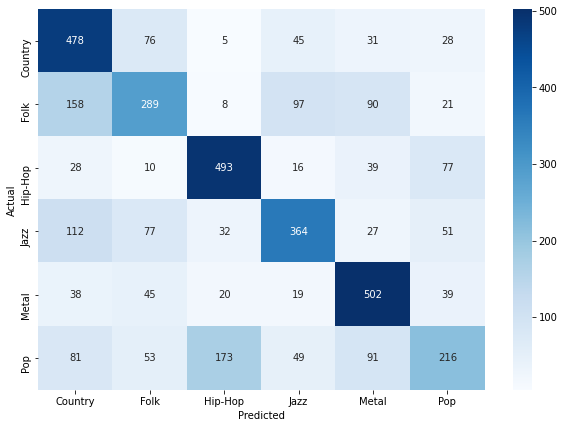

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


def get_recall(confusion_matrix):
  return torch.diag(confusion_matrix) / confusion_matrix.sum(dim = 1)

def get_precision(confusion_matrix):
  return torch.diag(confusion_matrix) / confusion_matrix.sum(dim = 0)

def get_accuracy(confusion_matrix):
  return torch.diag(confusion_matrix).sum() / confusion_matrix.sum()

def plot_confusion_matrix(confusion_matrix):
  df_cm = pd.DataFrame(confusion_matrix.cpu().numpy(), 
                     index = all_labels,
                     columns = all_labels)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')  
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

def plot_statistics(confusion_matrix):
  accuracy = get_accuracy(confusion_matrix)
  print("Accuracy:", accuracy.item())

  recall = get_recall(confusion_matrix)
  precision = get_precision(confusion_matrix)

  return pd.DataFrame({"Precision": precision.cpu().numpy(), "Recall": recall.cpu().numpy()}, index = all_labels)

plot_confusion_matrix(confusion_matrix)
plot_statistics(confusion_matrix)

In [ ]:
plot_statistics(confusion_matrix)

Implementation Notes:
1. Split songs up into stanzas with 150 words each
2. Truncated it at 512 tokens (due to BERT limits)
3. Used GRU to combine information from each word in the song, LSTM does not improve performance
4. Spread across 5 genres as default
5. Equal number of datapoints for each genre
6. Different transformer types - ALBERT did not improve performance

Ideas:
1. Look into distribution within training/testing sample (maybe skewed??, not that many Metal/Rock examples?) --> Fixed, uniform distribution now
2. Add more layers/hidden size, train our own BERT with a larger token size
3. Get around truncation by splitting up songs by stanza/line --> implemented
4. Limit it to only genres with a lot of datapoints

In [ ]:
utils.save_model(model, "/content/transformer_classification_model.pt")